In [1]:
import xarray as xa
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pylibs.plot_utils import set_size, setupax_2dmap

In [2]:
iodafile = '/glade/derecho/scratch/swei/Dataset/experiments/9badfd/fb/viirs_j1_albedo-thinned_p99/fb.viirs_j1_albedo-thinned_p99.2021082318.nc4'
pltgrp = 'hofx0'
pltvar = 'albedo'
pltch = 9

In [3]:
dims_ds = xa.open_dataset(iodafile)
channel = dims_ds.Channel.values
meta_ds = xa.open_dataset(iodafile, group='MetaData').assign_coords(Channel=channel.astype(np.int32))
obs_ds = xa.open_dataset(iodafile, group='ObsValue').assign_coords(Channel=channel.astype(np.int32))
plotting_ds = xa.open_dataset(iodafile, group=pltgrp).assign_coords(Channel=channel.astype(np.int32))
pltdata = plotting_ds[pltvar].sel(Channel=pltch).data

In [4]:
lats = meta_ds.latitude.data
lons = meta_ds.longitude.data
solarza = meta_ds.solarZenithAngle.data
glint_angle = np.rad2deg( np.arccos(np.cos(np.deg2rad(solarza))*np.cos(np.deg2rad(meta_ds.sensorZenithAngle.data))
                                    + np.sin(np.deg2rad(solarza))*np.sin(np.deg2rad(meta_ds.sensorZenithAngle.data)) * 
                                    np.cos(np.deg2rad(meta_ds.solarAzimuthAngle.data - meta_ds.sensorAzimuthAngle.data + 180.))) )
# water_mask = meta_ds.surfaceQualifier.data ==

In [6]:
# area corner [lats.min(), lats.max(), lons.min(), lons.max()]
# area_corner = [-90., 90., -150., 0.] # original cut
area_corner = [-10., 36., -46., 0.] # EAtl
# area_corner = [-40., 10., -90., -30.] # SAmer
# area_corner = [20., 60., -130., -50.] # NAmer
area_mask = (lats > area_corner[0])&(lats < area_corner[1])&(lons > area_corner[2])&(lons < area_corner[3])

In [7]:
gas_correction_coeff = np.ones(meta_ds.Channel.size, dtype=np.float32)
gas_correction_coeff[2] = 1./np.exp(-1.97e-4)*np.exp(-7.26e-3)*np.exp(-9.48e-4)
gas_correction_coeff[3] = 1./np.exp(-5.16e-4)*np.exp(-3.43e-2)*np.exp(-1.38e-3)
gas_correction_coeff[4] = 1./np.exp(-2.05e-3)*np.exp(-1.64e-2)*np.exp(-1.12e-5)
gas_correction_coeff[6] = 1./np.exp(-2.51e-3)*np.exp(-7.06e-4)*np.exp(-7.02e-5)
gas_correction_coeff[7] = 1./np.exp(-1.20e-2)*np.exp(-1.19e-7)*np.exp(-1.17e-2)
gas_correction_coeff[9] = 1./np.exp(-3.27e-3)*np.exp(-8.91e-7)*np.exp(-1.79e-2)
gas_correction_coeff[10] = 1./np.exp(-1.18e-2)*np.exp(-1.27e-6)*np.exp(-4.92e-2)

In [8]:
obs_ds *= gas_correction_coeff

In [9]:
proj = ccrs.PlateCarree()

In [10]:
data_dict = {
    'pltdata': (['locs'], pltdata),
    'obs': (['locs'], obs_ds[pltvar].sel(Channel=pltch).data),
    'lat': (['locs'], lats),
    'lon': (['locs'], lons),
    'solarza':(['locs'], solarza)
}
coord_dict = {'locs': range(pltdata.size)}
pltds = xa.Dataset(data_dict, coords=coord_dict)

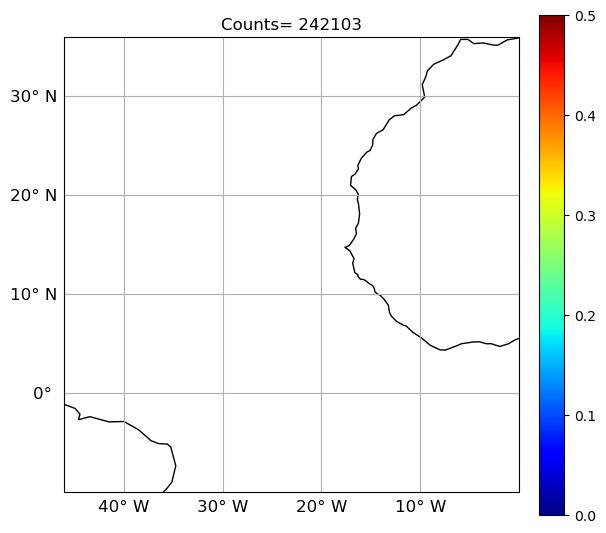

In [11]:
fig, ax, gl = setupax_2dmap(area_corner, None, proj, lbsize=12)
set_size(5, 6)
sc = ax.scatter(pltds.lon[area_mask],
                pltds.lat[area_mask],
                c=pltds.pltdata[area_mask],
                s=1,
                vmin=0.,
                vmax=0.5,
                cmap='jet')
cnts = np.count_nonzero(area_mask)
ax.set_title(f"Counts= {cnts}")
plt.colorbar(sc, fraction=0.05, pad=0.04, aspect=20)

In [52]:
fig.savefig('EAtl.no_qc.png', dpi=300)

In [82]:
nan_mask = pltds.pltdata.isnull().data
valid_range_mask = (pltds.pltdata.data <= 1.)&(pltds.pltdata.data >= 0.)
daylight_mask = (pltds.solarza.data < 84.)
thickcloud_mask = obs_ds[pltvar].sel(Channel=3).data > 0.4
glint_angle_mask = glint_angle <= 40

In [54]:
m9_data = obs_ds[pltvar].sel(Channel=9).data
m8_data = obs_ds[pltvar].sel(Channel=8).data
m8_data = np.where(m8_data == 0., np.nan, m8_data)
m8m9_valid = ~np.isnan(m9_data)&~np.isnan(m8_data)
m9_ovr_m8 = np.full_like(m9_data, np.nan)
m9_ovr_m8[m8m9_valid] = m9_data[m8m9_valid]/m8_data[m8m9_valid]
cirrus_cld_mask = (m9_data > 0.03)|((0.005 <= m9_data) & ((m9_data <= 0.3) & (m9_ovr_m8 > 0.3)))
del(m9_data, m8_data, m8m9_valid, m9_ovr_m8)

In [55]:
m5_data = np.where(obs_ds[pltvar].sel(Channel=5).data == 0., np.nan, obs_ds[pltvar].sel(Channel=5).data)
m4m5_valid = ~np.isnan(obs_ds[pltvar].sel(Channel=4).data)&~np.isnan(m5_data)
m4_ovr_m5 = np.full_like(m5_data, np.nan)
m4_ovr_m5[m4m5_valid] = obs_ds[pltvar].sel(Channel=4).data[m4m5_valid]/m5_data[m4m5_valid]
heavy_dust_in_glint_mask = (m4_ovr_m5 < 0.95) & (glint_angle_mask)
m3m5_valid = ~np.isnan(obs_ds[pltvar].sel(Channel=3).data)&~np.isnan(m5_data)
m3_ovr_m5 = np.full_like(m5_data, np.nan)
m3_ovr_m5[m3m5_valid] = obs_ds[pltvar].sel(Channel=3).data[m3m5_valid]/m5_data[m3m5_valid]
dust_mask = m3_ovr_m5 < 0.75
del(m5_data, m4m5_valid, m4_ovr_m5, m3m5_valid, m3_ovr_m5)

In [83]:
pltmsk = ( (daylight_mask & valid_range_mask & ~nan_mask)
          #& ~thickcloud_mask
          #& ~cirrus_cld_mask
          #& ~glint_angle_mask
          #| dust_mask
          #| heavy_dust_in_glint_mask
         )
pltmsk_cnts = pltmsk.nonzero()[0].size
pltmsk_percentage = pltmsk_cnts / pltdata.size * 100
pltmsk = pltmsk&area_mask
mskcnts = pltmsk.nonzero()[0].size

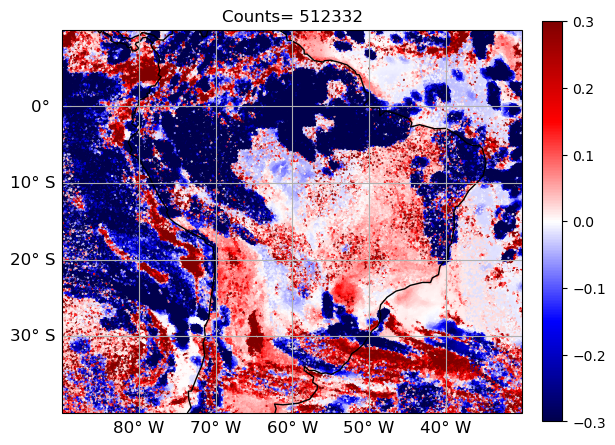

In [84]:
fig, ax, gl = setupax_2dmap(area_corner, None, proj, lbsize=12)
set_size(5, 6)
sc = ax.scatter(pltds.lon[pltmsk],
                pltds.lat[pltmsk],
                c=pltds.pltdata[pltmsk],
                s=0.25, vmin=-0.3, vmax=0.3, cmap='seismic')
ax.set_title(f"Counts= {mskcnts}")
# ax.set_title(f"{pltmsk_cnts} of {pltdata.size} ({pltmsk_percentage:.2f}%)")
plt.colorbar(sc, fraction=0.04, pad=0.04, aspect=20)

In [78]:
fig.savefig('SAmer.OMB_DT_CldsRemoved.png', dpi=300)

In [37]:
tmpds = pltds.pltdata[(daylight_mask & valid_range_mask & ~nan_mask)]

(array([307164., 508530., 282513., 171693., 130091., 116830., 118602.,
        127709., 139384., 151319., 153099., 134316., 100442.,  76033.,
         58826.,  43518.,  25286.,  10380.,   5049.,   2238.]),
 array([0.03086021, 0.07931714, 0.12777407, 0.176231  , 0.22468793,
        0.27314487, 0.32160178, 0.37005872, 0.41851565, 0.46697259,
        0.5154295 , 0.56388646, 0.61234337, 0.66080028, 0.70925725,
        0.75771415, 0.80617106, 0.85462803, 0.90308493, 0.9515419 ,
        0.99999881]),
 <BarContainer object of 20 artists>)

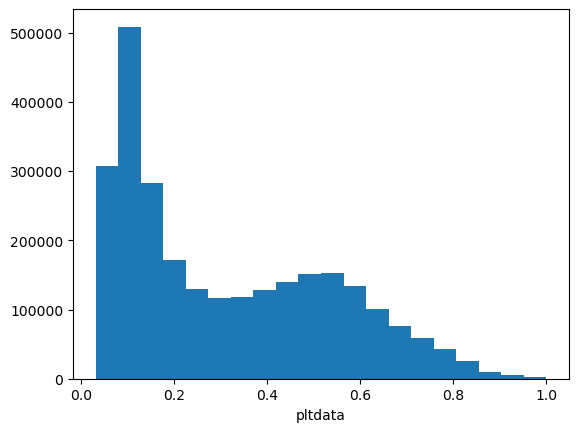

In [38]:
tmpds.plot.hist(
    bins=20,
)